In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.finance.components.uncertainty_problems import EuropeanCallExpectedValue
from qiskit.aqua.components.uncertainty_models import UnivariateVariationalDistribution, NormalDistribution
from qiskit.aqua.components.variational_forms import RY
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.initial_states import Custom

from qiskit.aqua import aqua_globals, QuantumInstance

from qiskit import BasicAer

In [2]:
bounds = np.array([0.,7.])
# Set number of qubits used in the uncertainty model
num_qubits = [3]

# Set entangler map
entangler_map = []
for i in range(sum(num_qubits)):
    entangler_map.append([i, int(np.mod(i+1, sum(num_qubits)))])

# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694,  0.07245791, 6.02626428, 0.13537225]
# Set an initial state for the generator circuit
init_dist = NormalDistribution(int(sum(num_qubits)), mu=1., sigma=1., low=bounds[0], high=bounds[1])
init_distribution = np.sqrt(init_dist.probabilities)
init_distribution = Custom(num_qubits=sum(num_qubits), state_vector=init_distribution)

var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state=init_distribution,
              entangler_map=entangler_map, entanglement_gate='cz')
theta = ParameterVector('θ', var_form.num_parameters)
var_form = var_form.construct_circuit(theta)
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, g_params,
                                              low=bounds[0], high=bounds[1])
g_circuit._var_form_params = theta
# construct circuit factory for uncertainty model
uncertainty_model = g_circuit

<ipython-input-2-342511257e91>:17: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state=init_distribution,


In [3]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.25

# construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    uncertainty_model,
    strike_price=strike_price,
    c_approx=c_approx
)

<ipython-input-4-80ccf065b2d9>:5: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state=init_distribution,


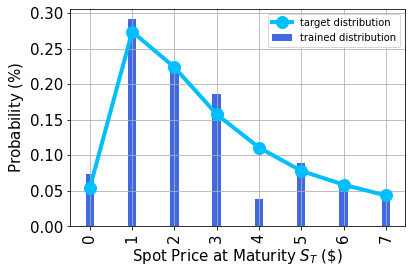

In [4]:
#trained probability distribution
init_distribution = np.sqrt(init_dist.probabilities)
init_distribution = Custom(num_qubits=sum(num_qubits), state_vector=init_distribution)

var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state=init_distribution,
              entangler_map=entangler_map, entanglement_gate='cz')
theta = ParameterVector('θ', var_form.num_parameters)
var_form = var_form.construct_circuit(theta)
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, g_params, low=bounds[0], high=bounds[1])
g_circuit._var_form_params = theta
uncertainty_model = g_circuit
uncertainty_model.set_probabilities(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
x = uncertainty_model.values
y = uncertainty_model.probabilities
#target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]

log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal==i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))


plt.bar(x, y, width=0.2, label='trained distribution', color='royalblue')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.plot(log_normal_samples,'-o', color ='deepskyblue', label='target distribution', linewidth=4, markersize=12)
plt.legend(loc='best')
plt.show()

Analytically calculated expected payoff w.r.t. the target distribution:  1.0641873115355054
Analytically calculated expected payoff w.r.t. the trained distribution:  0.9805308332649456
Expected payoff calculated with Quantum Amplitude Estimation: 	1.2580
Probability: 	0.8785


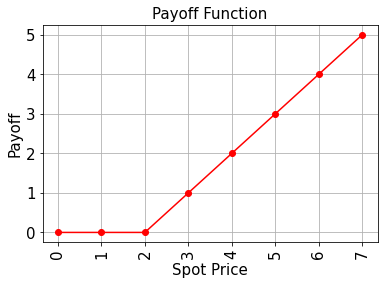

In [5]:
payoff = np.array([0,0,0,1,2,3,4,5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution: ", ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: ", ep_trained)

# set number of evaluation qubits (samples)
m = 5

# construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))
print('Expected payoff calculated with Quantum Amplitude Estimation: \t%.4f' % result['estimation'])
print('Probability: \t%.4f' % result['max_probability'])

# plot exact payoff function (evaluated on the grid of the trained uncertainty model)
x = uncertainty_model.values
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()